# 第一步.准备数据

In [ ]:
import requests
import base64
import io
import os
from string import digits
import json
from progressbar import *  

#### 通过百度OCR进行转换
编写转换器

In [ ]:
class OCR_baidu():
    def ocr(self,path):
        access_token = "24.ff9083e7515398cf32304ddf527cd0ca.2592000.1552380000.282335-15539881"
        with open(path, 'rb') as f:
            image_data = f.read()
            base64_ima = base64.b64encode(image_data)
            data = {
                'image': base64_ima
            }
            headers = {
                'Content-Type':'application/x-www-form-urlencoded'
            }
            url = "https://aip.baidubce.com/rest/2.0/ocr/v1/general_basic?access_token=" + str(access_token)
            r = requests.post(url,params = headers,data = data).json()
            for word in r['words_result']:
                yield word['words']

#### 确定要上传的图片

In [ ]:
imagedir = r'C:\Users\18501\Pictures\木心诗集\截图（有标题）'

#### 开始进行文字识别

In [ ]:
i = 1
total = 301
pbar = ProgressBar().start()
for parent,dirnames,filenames in os.walk(imagedir):
    for filename in filenames:
        
        currentpath = os.path.join(parent,filename)
        ocr = OCR_baidu()
        path = currentpath
        words = ocr.ocr(path)
        
        n = 1
          
        
        for word in words:
            
            if n == 1:
                remove_digits = str.maketrans('','',digits)
                res = word.translate(remove_digits)+ ':'
                open(r'C:\Users\18501\Pictures\木心诗集\OCR结果\诗经演.txt','a').write(res)
            if n > 1:
                remove_digits = str.maketrans('','',digits)
                res = word.translate(remove_digits)+ ','
                open(r'C:\Users\18501\Pictures\木心诗集\OCR结果\诗经演.txt','a').write(res)
            n = n + 1     
            
        temp = '\n'
        open(r'C:\Users\18501\Pictures\木心诗集\OCR结果\诗经演.txt','a').write(temp) 
        
        pbar.update(int((i / (total - 1)) * 100))
        i = i + 1
pbar.finish()  

# 第二步.开始建模

## 准备工作

In [1]:
import io
import collections
import sys

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


### 数据整理

In [3]:

poetry_file ='诗经演.txt'

# 诗集
poems = []
with io.open(poetry_file, "r", encoding='GBK',) as f:
    for line in f:
        try:
            title, content = line.strip().split(u':')
            content = content.replace(u' ',u'')  
            if '_' in content or u'(' in content or u'（' in content or u'《' in content or u'[' in content:
                continue
            if len(content) < 5 or len(content) > 79:
                continue
            content = u'[' + content + u']'
            poems.append(content)
        except Exception as e:
            pass

# 按诗的字数排序
poems = sorted(poems, key=lambda line: len(line))
MAX_LEN = max(map(len, poems))
print('诗经演总量: ', len(poems))

spaced_poems = list(map(lambda poem: ' '.join(poem), poems))

partial_poems = []
next_chars = []
for poem in poems:
    for i in range(1, len(poem)):
        partial_poems.append(poem[:i])
        next_chars.append(poem[i])


诗经演总量:  300


### 把诗全部补齐字数

In [4]:
tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(spaced_poems)
to_seq = lambda x: pad_sequences(tokenizer.texts_to_sequences(x), maxlen=MAX_LEN, padding='pre')

In [5]:
def batch_generator(texts, next_chars, batch_size, tokenizer, max_len):
    n = len(texts)
    n_words = len(tokenizer.word_counts)
    while True:
        inds = np.random.randint(0, n, size=batch_size)
        batch_texts = []
        batch_next_chars = []
        for ind in inds:
            batch_texts.append(texts[ind])
            batch_next_chars.append(next_chars[ind])
#         print(batch_texts)
        x_batch = pad_sequences(tokenizer.texts_to_sequences(map(lambda text: ' '.join(text), batch_texts)), maxlen=max_len, padding='pre')
        y_batch = tokenizer.texts_to_matrix(batch_next_chars)
        yield (x_batch, y_batch)
        

In [6]:
def batch_cycle_generator(texts, next_chars, batch_size, tokenizer, max_len):
    n = len(texts)
    n_words = len(tokenizer.word_counts)
    ind = 0
    while True:
        batch_texts = []
        batch_next_chars = []
        for _ in range(batch_size):
            batch_texts.append(texts[ind])
            batch_next_chars.append(next_chars[ind])
            ind = (ind + 1) % n
#         print(batch_texts)
        x_batch = pad_sequences(tokenizer.texts_to_sequences(map(lambda text: ' '.join(text), batch_texts)), maxlen=max_len, padding='pre')
        y_batch = tokenizer.texts_to_matrix(batch_next_chars)
        yield (x_batch, y_batch)
        

### 参数设置

In [7]:
# 参数
UNITS = 128
N_LAYERS = 2
DIM_EMBED = 50
VOCAB = len(tokenizer.word_counts) + 1
BATCH_SIZE = 64

## 建模

In [8]:
import keras
from keras.layers import Dense, Activation, LSTM, GRU, SimpleRNN, Input, Embedding, Dropout
from keras.models import Model

In [9]:
input_shape = (MAX_LEN, )
input_layer = Input(shape=input_shape)
z = input_layer


z = Embedding(VOCAB, DIM_EMBED, input_length=MAX_LEN, trainable=True)(z)
z = Dropout(0.4)(z)

z = GRU(UNITS, return_sequences=True)(z)
z = GRU(UNITS)(z)
z = Dense(VOCAB)(z)
z = Activation('softmax')(z)

model = Model(input_layer, z)
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.RMSprop(),
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 50)            132800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 80, 128)           68736     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_1 (Dense)              (None, 2656)              342624    
_________________________________________________________________
activation_1 (Activation)    (None, 2656)              0         
Total para

## 训练并观察结果

In [10]:
gen = batch_generator(partial_poems, next_chars, BATCH_SIZE, tokenizer, MAX_LEN)

In [11]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)    
#     probas = np.random.multinomial(1, preds, 1)
#     return np.argmax(probas)
    return np.random.choice(len(preds), p=preds)

In [12]:
indices_char = {v: k for k, v in tokenizer.word_index.items()}

losses = []
# range(61)
for iteration in range(100):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    train_info = model.fit_generator(gen, 1000, epochs=1)
    losses.append(train_info.history['loss'][0])

    if iteration % 5 == 0:
        print('Generating text')
        for diversity in [0.2, 0.5, 1.0, 1.2]:
    #     for diversity in [0.2, 0.5, 1.0]:
            print()
            print('----- diversity:', diversity)

            generated = '['
            print('----- Generating with seed: "' + generated + '"')
            sys.stdout.write(generated)

            for i in range(81):
                x = pad_sequences(tokenizer.texts_to_sequences([' '.join(generated)]), maxlen=MAX_LEN, padding='pre')

                preds = model.predict(x, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                generated += next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
                if next_char == ']':
                    break
            print()


--------------------------------------------------
Iteration 0
Epoch 1/1
1000/1000 [==============================] - 220s 220ms/step - loss: 5.4132
Generating text

----- diversity: 0.2
----- Generating with seed: "["
[有彼我之,有我有矣,维有有矣,不我不,不之之,不子之,不之之,不之之,有不之,不之之,不之之,岂之之,]

----- diversity: 0.5
----- Generating with seed: "["
[于其其处,有我人矣,有彼有彊,不子不心,我靡不且,不我之信,是然其青,民之所矣,不则无中,匪南于矣,维言之矣,胡子为枝,胡于不矣,以身子兮,]

----- diversity: 1.0
----- Generating with seed: "["
[未施舆天,言在飨蹶,淳栖立飞,傩既不←,谗不湛中,有因有迩,平渺瘵必,燕然束泛,乃旐载穑,匪伐大予,鸿贤兮高,何燕葑亡,圣如牙甘,舄冲重桐,珉趣而貊,]

----- diversity: 1.2
----- Generating with seed: "["
[于子彊成,蹊兮釆穗,胡纳嘌中,无诚中来,旁射獾幽,载立曜饧,蔚弗览兮,轲仰尔木,替垚生殖,采友庭悄,悠彼中凄,倒然写攸,捕总斯与,告觉孑霖,苕]

--------------------------------------------------
Iteration 1
Epoch 1/1
1000/1000 [==============================] - 209s 209ms/step - loss: 5.0654

--------------------------------------------------
Iteration 2
Epoch 1/1
1000/1000 [==============================] - 210s 210ms/step - loss: 4.9272

--------------------------------------

1000/1000 [==============================] - 179s 179ms/step - loss: 3.7241

--------------------------------------------------
Iteration 32
Epoch 1/1
1000/1000 [==============================] - 179s 179ms/step - loss: 3.7232

--------------------------------------------------
Iteration 33
Epoch 1/1
1000/1000 [==============================] - 179s 179ms/step - loss: 3.6857

--------------------------------------------------
Iteration 34
Epoch 1/1
1000/1000 [==============================] - 180s 180ms/step - loss: 3.6810

--------------------------------------------------
Iteration 35
Epoch 1/1
1000/1000 [==============================] - 179s 179ms/step - loss: 3.6379
Generating text

----- diversity: 0.2
----- Generating with seed: "["
[有谓者木,不可成焉,彼淇之子,无何其其,不方有如,其尔是若,以时不今,不我矣居,天有自天,天之有大,其国有南,矣思无,维君之子,不可与乎,]

----- diversity: 0.5
----- Generating with seed: "["
[王之在,大心君子,彼其君子,谓如有道,匪可山也,何有有也,良有小,]

----- diversity: 1.0
----- Generating with seed: "["
[之授无欲,有复予弥,厥其穀止,将彼今遑,土室不子,有将载衣,如鱼清

1000/1000 [==============================] - 179s 179ms/step - loss: 3.4574

--------------------------------------------------
Iteration 65
Epoch 1/1
1000/1000 [==============================] - 180s 180ms/step - loss: 3.4708
Generating text

----- diversity: 0.2
----- Generating with seed: "["
[彼何人斯,其为风风,胡彼自南,无然无我,厥其有日,思人矣矣,无尔无然,无无载,君子有酒,君子有有,予予尔矣,不之无之,矣日无胡,南之有良,,]

----- diversity: 0.5
----- Generating with seed: "["
[彼何人斯,其为风兮,维其尔矣,为其其厥,彼与子,在人之正,有如有木,岂弟君子,我之为,情之济,是人于且,中谁则美,尔与尔云,风心尔野,弟彼一心,]

----- diversity: 1.0
----- Generating with seed: "["
[玉日牡巅,草兮胡木,止子必也,盈在从矣,武怀永期,靡然羽好,自极于适,其事且酒,扬焉奕言,]

----- diversity: 1.2
----- Generating with seed: "["
[辟场缁采,其,照甘,之报,倏之,甘夫忧,中疾白则,靖违履锐,同亟贤庸,必息宿山,忧之清矣,,实有风,蒿之佩淇,徂不视西,厥嗟耽越,椒其丝百是,,]

--------------------------------------------------
Iteration 66
Epoch 1/1
1000/1000 [==============================] - 181s 181ms/step - loss: 3.4701

--------------------------------------------------
Iteration 67
Epoch 1/1
1000/1000 [==============================] -

[之谋有东,其叶其为,良有信矣,言其生,龙亦其百,我在其命,于有其体,有水有酒,载不为载,如只其已,我尔之思,不可衣也,于言其国,不清其能,]

----- diversity: 1.0
----- Generating with seed: "["
[有庭者奥,有履实吾,将食死迨,维心浚路,已智泛丘,爰何我已,烈亦耽在,能棣之重,不海于招,旨能令思,载谋迈日,]

----- diversity: 1.2
----- Generating with seed: "["
[必子哲下,来既疾贪,棣兹帝尚,怀徂渺佼,顺忘谋右,飞外尚旃,乃遑不羊,乐众我饥,犹能朝礼,物号子尚,纠正泄酒,城二外德,悠马有止,生堂爰梁,,]

--------------------------------------------------
Iteration 96
Epoch 1/1
1000/1000 [==============================] - 179s 179ms/step - loss: 3.4264s - loss: 

--------------------------------------------------
Iteration 97
Epoch 1/1
1000/1000 [==============================] - 180s 180ms/step - loss: 3.4235

--------------------------------------------------
Iteration 98
Epoch 1/1
1000/1000 [==============================] - 180s 180ms/step - loss: 3.4041

--------------------------------------------------
Iteration 99
Epoch 1/1
1000/1000 [==============================] - 181s 181ms/step - loss: 3.4432


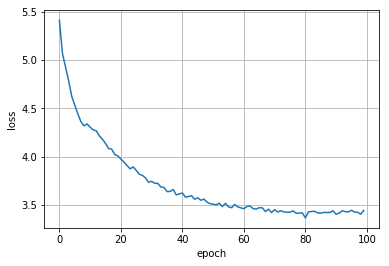

In [13]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

In [16]:
model.save('poet_2gru.h5')

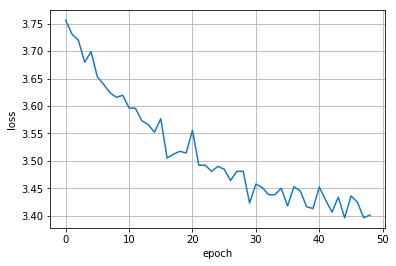

In [17]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

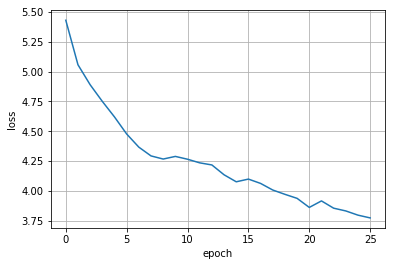

In [15]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

In [36]:
sys.stdout.write(generated)

[自切于高,是殷之焉,芃云莫子,人青视二,阳在甫居,禄谷尚厥,无泉偕吾,维象今衣,婉吉亦神,不定躇戾,虽之莫之,兄复之居,海侧南播,恺率心观,]

In [15]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
